# Cost Functions

A quick guide on how to use the built-in cost functions.

The Minuit2.jl package comes with a couple of common cost functions. Of course, you can write your own cost functions to use with Minuit2, but most of the cost function is always the same. What really varies is the statistical model which predicts the probability density as a function of the parameter values.

We demonstrate each cost function on a standard example from high-energy physics, the fit of a peak over some smooth background.

In [1]:
using Revise
using Minuit2
using Distributions
using FHist
using Plots

We generate our data by sampling from a Gaussian peak and from exponential background in the range 0 to 2. The original data is then binned. One can fit the original or the binned data.

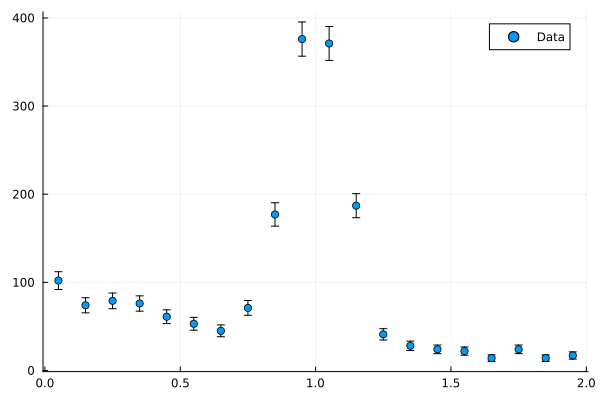

In [2]:
rng = (0, 2)
xdata = 0.1 .* randn(1000) .+ 1
ydata = rand(Exponential(1), length(xdata))
xmix = vcat(xdata, ydata)
xmix = xmix[(rng[1] .< xmix .< rng[2])]
h = Hist1D(xmix, binedges=range(rng..., 21))
x = bincenters(h)
y = bincounts(h)
dy = sqrt.(y)
plot(x, y, yerr=dy, seriestype=:scatter, label="Data")


We also generate some 2D data to demonstrate multivariate fits. In this case, a Gaussian along axis 1 and independently an exponential along axis 2. In this case, the distributions are not restricted to some range in x and y.

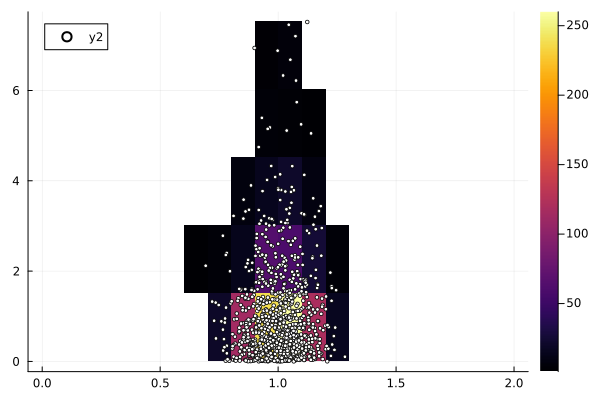

In [3]:
h2 = Hist2D((xdata, ydata), binedges=(range(rng..., 21), range(0., maximum(ydata), 6)))
plot(h2)
scatter!(xdata, ydata, markersize=2, color=:white)

## Maximum-likelihood fits

Maximum-likelihood fits are the state-of-the-art when it comes to fitting models to data. They can be applied to unbinned and binned data (histograms).

Unbinned fits are the easiest to use, because no data binning is needed. They become slow when the sample size is large.
Binned fits require you to appropriately bin the data. The binning has to be fine enough to retain all essential information. Binned fits are much faster when the sample size is large

### Unbinned fit

Unbinned fits are ideal when the data samples are not too large or very high dimensional. 
There is no need to worry about the appropriate binning of the data. Unbinned fits are inefficient 
when the samples are very large and can become numerically unstable, too. 
Binned fits are a better choice then.

The cost function an unbinned maximum-likelihood fit is really simple, it is the sum of the 
logarithm of the pdf evaluated at each sample point (times -1 to turn maximization into minimization).
You can easily write this yourself, but a naive implementation will suffer from instabilities 
when the pdf becomes locally zero. Our implementation mitigates the instabilities to some extent.
To perform the unbinned fit you need to provide the pdf of the model, which must be vectorized (a Numpy ufunc). 

The pdf must be normalized, which means that the integral over the sample value range must be a 
constant for any combination of model parameters. The model pdf in this case is a linear combination 
of the normal and the exponential pdfs. The parameters are  (the weight),  and  of the normal distribution and  of the exponential. The cost function detects the parameter names.

It is important to put appropriate limits on the parameters, so that the problem does not become mathematically undefined.

,
,
.
In addition, it can be beneficial to use , but it is not required. We use truncnorm and truncexpon, which are normalized inside the data range (0, 2).

In [4]:
model(x, ζ, μ, σ, τ) = ζ * pdf(truncated(Normal(μ, σ), rng...),x) + (1 - ζ) * pdf(truncated(Exponential(τ), rng...), x)
cost = LeastSquares(x, y, dy, model)

m = Minuit(cost, ζ=0.5, μ=1, σ=0.5, τ=1, limit_ζ=(0, 1), limit_μ=(0, 2), limit_σ=(0, 2), limit_τ=(0, 2))

Minuit(FCN = LeastSquares, X0 = Real[0.5, 1, 0.5, 1], Method = migrad)

In [5]:
migrad!(m)

┌──────────────┬──────────────┬───────────┬────────────┬───────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ Up        │
│ 1836.06      │              │ 95        │ 4          │ 1.0       │
├──────────────┼──────────────┼───────────┼────────────┼───────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │ Call limit │ Edm       │
│ true         │ true         │ false     │ false      │ 8.8341e-5 │
├──────────────┼──────────────┼───────────┼────────────┼───────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced    │
│ false        │ true         │ true      │ true       │ false     │
└──────────────┴──────────────┴───────────┴────────────┴───────────┘
┌───┬──────┬──────────┬─────────────┬────────┬────────┬────────┬────────┬───────
│   │ Name │ Value    │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixe ⋯
├───┼──────┼──────────┼─────────────┼────────┼────────┼────────┼────────┼───────
│ 1 │ ζ    │ 0.564614 │ 0.643053    │        │        │ 0.0    │ 1.

## Least-squares fits

A cost function for a general weighted least-squares fit (aka chi-square fit) is also included. In statistics this is called non-linear regression.

In this case you need to provide a model that predicts the y-values as a function of the x-values and the parameters. The fit needs estimates of the y-errors. If those are wrong, the fit may be biased. If your data has errors on the x-values as well, checkout the tutorial about automatic differentiation, which includes an application of that to such fits.

In [ ]:
# Define the model
model(x, a, b) = a + b * x^2

# Define the data and truth
truth = 1, 2
x = range(0, 1., 20)
yt = model.(x, truth...)
ye = 0.4 .* x.^5 .+ 0.1
y = yt + ye .* randn(length(x))

# Plot with error bars
plot(x, y, yerr=ye, seriestype=:scatter, label="Data")
plot!(x, yt, label="Truth", linestyle=:dash)

In [ ]:
c = LeastSquares(x, y, ye, model)
m1 = Minuit(c, a=0, b=0)
migrad!(m1)
visualize(m1)

In [ ]:
m1.parameters

### Multivariate model

In [ ]:
function model2(xy, a, bx, by)
    x, y = xy
    return a + bx * x + by * y
end

function model2_grad(xy, a, bx, by)
    x, y = xy
    return [1, x, y]
end

# generate a regular grid in x and y
xy = [(x,y) for x in range(-1.,1.,10) for y in range(-1.,1.,10)]

# model truth 
zt = model2.(xy, 1, 2, 3)

zerror = 1.
z = zt .+ zerror .* randn(length(xy))

scatter(xy, zcolor=z)

In [ ]:
c2 = LeastSquares(xy, z, zerror, model2)
m2 = Minuit(c2, 0, 0, 0)
migrad!(m2)

Multivariate fits are difficult to check by eye. Here we use color to indicate the function value.

To guarantee that plot of the function and the plot of the data use the same color scale.

In [ ]:
heatmap(range(-1.,1.,100), range(-1.,1.,100), (x,y)->model2((x,y), m2.values...))
scatter!(xy, zcolor=z)

Let's use the gradient in a multi-variate

In [ ]:
c2 = LeastSquares(xy, z, zerror, model2, model_grad=model2_grad)
m2 = Minuit(c2, 0, 0, 0)
migrad!(m2)

### Robust least-squared
The built-in least-squares function also supports robust fitting with an alternative loss functions. Builtin loss functions are:

- linear (default): gives ordinary weighted least-squares
- soft_l1: quadratic ordinary loss for small deviations (<< 1σ), linear loss for large deviations (>> 1σ), and smooth interpolation in between

Let’s create one outlier and see what happens with ordinary loss.

In [ ]:
c.y[4] = 3.0   # Generate an outlier
migrad!(m1)
visualize(m1)
plot!(x, yt, label="Truth", linestyle=:dash)

In [ ]:
m1

We can mask the outlier temporary

In [ ]:
mask = c.y .!= 3.0
c.mask = mask
migrad!(m1)
visualize(m1)
plot!(x, yt, label="Truth", linestyle=:dash)

In [ ]:
m1.parameters

In [ ]:
c.mask = nothing
c.loss = :soft_l1
migrad!(m1)
visualize(m1)
plot!(x, yt, label="Truth", linestyle=:dash)

In [ ]:
m1.parameters